# Data preprocessing on PM2.5 dataset

Before performing any analysis, let's load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PATH="BeijingPM20100101_20151231.csv"

def load_dataset(filename):
    data=pd.read_csv(filename)
    cols=np.array(data.columns,dtype=np.str)
    stations=[]
    for col in cols:
        if col.startswith("PM_"):
            stations.append(col)
    return (data,stations)

data,stations=load_dataset(DATASET_PATH)
data.rename(columns={"No":"id"},inplace=True)
# We minus one so that the index will start from zero
data.index=data["id"]-1
data.drop("id",axis=1,inplace=True)

We do not need to analyze datetime features because they essentially serve as an identifier for each different row. As a result, we exclude them from further analysis

In [2]:
lblcols=["year","month","day","hour","season","cbwd"]
valcols=list(data.columns^lblcols)

## Correlation matrix for the dataset

Not only do we need to look at the value distribution of each feature, but also entail studying the relationship among different features.

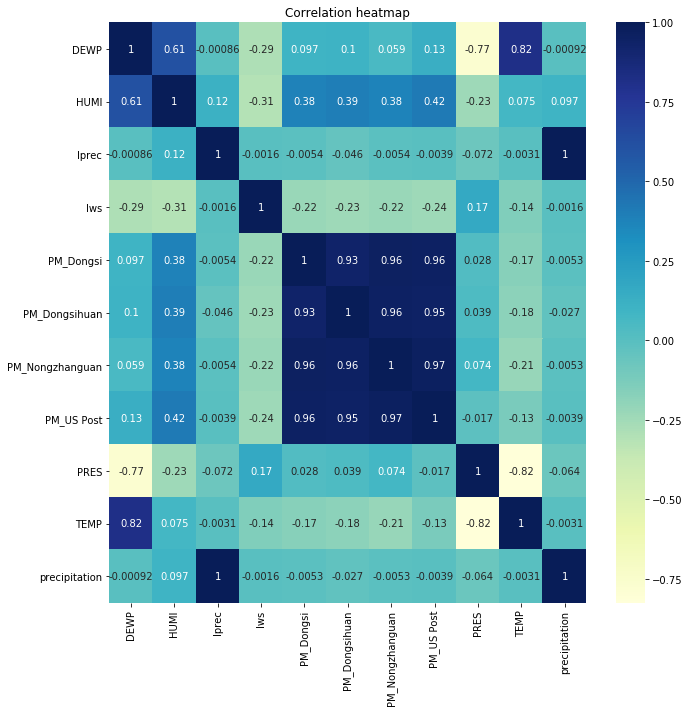

In [3]:
f=plt.figure(figsize=(10,10))
f.set_tight_layout(True)
ax=f.gca()
ax.set_title("Correlation heatmap")
sns.heatmap(data=data.loc[:,valcols].corr(),ax=ax,annot=True,cmap="YlGnBu")
plt.savefig("graphs/raw_corr.png")
plt.savefig("graphs/raw_corr.pdf")
plt.show()

According to the heatmap plot, `Iprec` and `precipitation` features are highy correlated, so we could consider preserving only one of them. Let's see how the errors between these `Iprec` and `precipitation` values are distributed.

In [4]:
print("Percentage of identical `Iprec' and `precipitation': %.2f%%" % (data.loc[data["precipitation"]==data["Iprec"]].shape[0]/data.shape[0]*100))

Percentage of identical `Iprec' and `precipitation': 96.41%


It turns out that we could indeed remove either `precipitation` or `Iprec` column in preprocessing.

In [5]:
data.drop("Iprec",axis=1,inplace=True)

In addition, we found that the PM2.5 concentration values measured in different stations are similar, so we decide to use PM2.5 concentration from the station that has the most complete record.

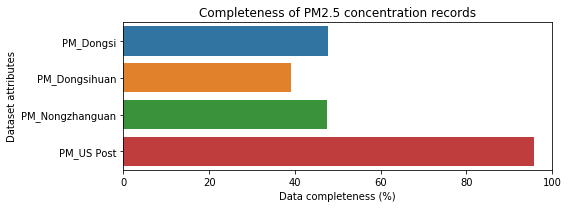

In [6]:
mrate={}
for col in stations:
    r=100*data.loc[~pd.isnull(data[col])].shape[0]/data.shape[0]
    mrate[col]=r

f=plt.figure(figsize=(8,3))
f.set_tight_layout(True)
ax=plt.gca()
sns.barplot(orient='h',y=list(mrate.keys()),x=list(mrate.values()),ax=ax)
ax.set_title("Completeness of PM2.5 concentration records")
ax.set_ylabel("Dataset attributes")
ax.set_xlabel("Data completeness (%)")
ax.set_xlim(0,100)
plt.savefig("graphs/pm_completeness.pdf")
plt.savefig("graphs/pm_completeness.png")

According to the above plot, we can see that `PM_US Post` contains the most complete set of PM2.5 concentration records, so we will use it to conduct further research.

In [7]:
for t in data.columns:
    if t.startswith("PM_") and t!="PM_US Post":
        data.drop(t,axis=1,inplace=True)

data.rename(columns={"PM_US Post":"PM"},inplace=True)
# Update `valcols'
valcols=list(data.columns^lblcols)

In [8]:
data[valcols].describe()

,DEWP,HUMI,Iws,PM,PRES,TEMP,precipitation
count,52579.000000,52245.000000,52579.000000,50387.000000,52245.000000,52579.000000,52100.000000
mean,2.074554,54.602421,23.261829,95.904241,1016.465442,12.587040,19.258683
std,14.222059,25.991338,49.281706,91.643772,10.295070,12.098527,4381.035532
min,-40.000000,2.000000,0.450000,1.000000,991.000000,-19.000000,0.000000
25%,-10.000000,31.000000,1.790000,27.000000,1008.000000,2.000000,0.000000
50%,2.000000,55.000000,4.920000,69.000000,1016.000000,14.000000,0.000000
75%,15.000000,78.000000,21.020000,132.000000,1025.000000,23.000000,0.000000
max,28.000000,100.000000,585.600000,994.000000,1046.000000,42.000000,999990.000000


## Outlier processing

We can see that columns like `precipitation` contains extremely large values, and these values are not realistic (e.g. it is impossible for Beijing to reach a precipitation of 999990 millimeters or a PM2.5 concentration of 994 $ug/m^3$). As a result, we need to remove these outliers, and we adopt the a strategy similar to [this paper][1]. We regard PM2.5 data values greater than 500 $ug/m^3$, precipitation values exceeding 400 millimeters, wind speed that tops 500 $m/s$, and air pressures thatgo beyond 2000 kPa as anomalies. Subsequently, these identified outliers will be removed and refilled using imputation methods.

[1]: http://doi.org/10.1109/ACCESS.2019.2897754

In [9]:
normal_ranges={
    "PM":500,
    "PRES":2000,
    "precipitation":400
}

for t in normal_ranges.keys():
    vmax=normal_ranges[t]
    data.loc[data[t]>vmax,t]=np.nan

data[valcols].describe()

,DEWP,HUMI,Iws,PM,PRES,TEMP,precipitation
count,52579.000000,52245.000000,52579.000000,50218.000000,52245.000000,52579.000000,52099.000000
mean,2.074554,54.602421,23.261829,94.257278,1016.465442,12.587040,0.065019
std,14.222059,25.991338,49.281706,87.095058,10.295070,12.098527,0.858786
min,-40.000000,2.000000,0.450000,1.000000,991.000000,-19.000000,0.000000
25%,-10.000000,31.000000,1.790000,27.000000,1008.000000,2.000000,0.000000
50%,2.000000,55.000000,4.920000,69.000000,1016.000000,14.000000,0.000000
75%,15.000000,78.000000,21.020000,132.000000,1025.000000,23.000000,0.000000
max,28.000000,100.000000,585.600000,500.000000,1046.000000,42.000000,69.200000


After removing outliers, we pay attention to missing values.

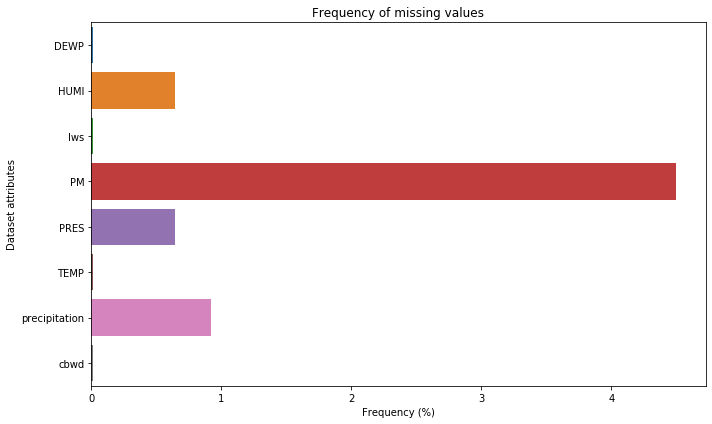

In [10]:
mrate={}

valcols.append("cbwd")
for col in valcols:
    r=100*data.loc[pd.isnull(data[col])].shape[0]/data.shape[0]
    mrate[col]=r
valcols.remove("cbwd")

f=plt.figure(figsize=(10,6))
f.set_tight_layout(True)
ax=plt.gca()
sns.barplot(orient='h',y=list(mrate.keys()),x=list(mrate.values()),ax=ax)
ax.set_title("Frequency of missing values")
ax.set_ylabel("Dataset attributes")
ax.set_xlabel("Frequency (%)")
plt.savefig("graphs/missing_val.png")
plt.savefig("graphs/missing_val.pdf")
plt.show()

## Missing value imputation

Nevertheless, the dataset contains missing values, so we need to make use of several techniques to impute. Specifically, we adopt NOCB to impute missing values at the beginning of the time series, LOCF for the end of the dataset, and linear interpolation for missing chunks within the time series.

### LOCF and NOCB imputation

LOCF (last observation carried forward) and NOCB (next observation carried backward), are some of the easiest method to impute missing values. Let $y_m$ and $y_n$ are two endpoints of a missing chunk in the time series, so for all $m<t<n$, LOCF and NOCB methods can be described as follows:

$$
\text{LOCF: }y_t=y_m \\
\text{NOCB: }y_t=y_n
$$

### Linear interpolation

Similarly, let $y_m$ and $y_n$ be two endpoints of a time series' missing chunk, so linear interpolation gives

$$
y={y_n-y_m\over n-m}(t-m)+y_m
$$

In [11]:
# Step 1: NOCB
def impute_nocb(series):
    nocb=0
    # Find the first non-null element
    while pd.isnull(series[nocb]) and nocb<series.shape[0]:
        nocb+=1
    # Fill them in
    for i in range(0,nocb):
        series[i]=series[nocb]
    return series

# Step 2: LOCF
def impute_locf(series):
    locf=series.shape[0]-1
    # Find the last non-null element
    while pd.isnull(series[locf]) and locf>=0:
        locf-=1
    # Fill them in
    for i in range(locf+1,series.shape[0]):
        series[i]=series[locf]
    return series

# Step 3: Linear interpolation
def impute_linear(series):
    # Iterate through every missing chunk
    t=0
    t0=0
    t1=0
    while t<series.shape[0]:
        if not pd.isnull(series[t]):
            t0=t
        else:
            for m in range(t+1,series.shape[0]):
                if not pd.isnull(series[m]):
                    t1=m
                    break
            # Now perform linear interpolation
            y0=series[t0]
            y1=series[t1]
            slope=(y1-y0)/(t1-t0)
            for m in range(t0+1,t1):
                series[m]=slope*(m-t0)+y0
            t=t1-1
        t+=1
    return series

for col in valcols:
    print("Imputing `%s': " % col,end='')
    series=np.array(data.loc[:,col])
    print("NOCB ok",end='')
    series=impute_nocb(series)
    print(", LOCF ok",end='')
    series=impute_locf(series)
    print(", Linear interpolation ok")
    series=impute_linear(series)
    data.loc[:,col]=series

Imputing `DEWP': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `HUMI': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `Iws': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `PM': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `PRES': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `TEMP': NOCB ok, LOCF ok, Linear interpolation ok
Imputing `precipitation': NOCB ok, LOCF ok, Linear interpolation ok


After performing imputation, we consider adding few more columns to facilitate further analytic works. For instance, we add a new `date` attributes that essentially combine values in `year`, `month`, `day`, and `hour` attributes, allowing us to locate the data values based on time.

In [12]:
data["date"]=pd.to_datetime(data[["year","month","day","hour"]])

## Wrapping `cbwd` attribute

Because `cbwd` (aka. combined wind direction) is not a numerical attribute, we are unable to preprocess them using methods done on other attributes, so we will perform `cbwd`-specific procedures in this separate section.

In [13]:
data["cbwd"].unique()

array(['NW', 'cv', 'NE', 'SE', nan], dtype=object)

Apparently it contains missing values, and it cannot be imputed using numerical methods, so we adopt NOCB on missing values at the beginning of `cbwd` time series and LOCF on the rest of the missing values.

In [14]:
cbwd_series=np.array(data["cbwd"],copy=True)

# We can still use the previously implemented impute_nocb() function to handle the missing values at the beginning
cbwd_tmp=impute_nocb(cbwd_series)

for t in range(len(cbwd_tmp)):
    # Since we have done NOCB, the first value cannot be NaN
    if pd.isnull(cbwd_tmp[t]):
        cbwd_tmp[t]=cbwd_tmp[t-1]

data["cbwd"]=cbwd_tmp
data["cbwd"].unique()

array(['NW', 'cv', 'NE', 'SE'], dtype=object)

In [15]:
data.loc[data["cbwd"]=="cv","Iws"].describe()

count    11414.000000
mean         2.092669
std          4.591167
min          0.450000
25%          0.890000
50%          1.340000
75%          2.230000
max         85.440000
Name: Iws, dtype: float64

From the imputed `cbwd`, we can see that the dataset only identifies four types of winds:

- **`cv`**: Still wind (wherever `data["cbwd"]=="cv"`, the `Iws` values are often low)
- **`NW`**: Northwestern wind
- **`NE`**: Northeastern wind
- **`SE`**: Southeastern wind

Consequently, we can create a simple numerical encoding for each type of wind:

In [16]:
data["cbwd"]=data["cbwd"].map({"cv":0,"NW":1,"NE":2,"SE":3})

In [17]:
data.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,date
id,,,,,,,,,,,,,,
0,2010,1,1,0,4,129.0,-21.0,43.0,1021.0,-11.0,1,1.79,0.0,2010-01-01 00:00:00
1,2010,1,1,1,4,129.0,-21.0,47.0,1020.0,-12.0,1,4.92,0.0,2010-01-01 01:00:00
2,2010,1,1,2,4,129.0,-21.0,43.0,1019.0,-11.0,1,6.71,0.0,2010-01-01 02:00:00
3,2010,1,1,3,4,129.0,-21.0,55.0,1019.0,-14.0,1,9.84,0.0,2010-01-01 03:00:00
4,2010,1,1,4,4,129.0,-20.0,51.0,1018.0,-12.0,1,12.97,0.0,2010-01-01 04:00:00


After data preprocessing, we can save our work for future use.

In [18]:
data.to_csv("BeijingPM_imputed.csv")